# Example implementation with Theano
In Theano the jvp operator is `theano.tensor.Rop` and the vjp operator is `theano.tensor.Lop`. I'm going to implement an 'alternative Rop' using two applications of `theano.tensor.Lop`, and demonstrate that the computation graphs that it produces are the same as those produced by `theano.tensor.Rop`.

Firstly import `theano.tensor`:

In [1]:
import theano.tensor as T

and let's take a quick look at the API for `Rop`, which we'll want to copy for our alternative implementation:

In [2]:
T.Rop?

```
Signature: T.Rop(f, wrt, eval_points)
Docstring:
Computes the R operation on `f` wrt to `wrt` evaluated at points given
in `eval_points`. Mathematically this stands for the jacobian of `f` wrt
to `wrt` right muliplied by the eval points.```

---

The important thing here is: `T.Rop(f, wrt, eval_points)` stands for 'the jacobian of `f` wrt to `wrt` right muliplied by the eval points'. So `wrt` was what I denoted $x$ above, and `eval_points` was denoted $u$.

I prefer my notation, so I'm going to use `x` and `u` for those variables. The signature of our alternative_Rop is going to look like this:

```python
def alternative_Rop(f, x, u):
```

The `theano.tensor.Lop` API matches that of `Rop`. So `T.Lop(f, wrt, eval_points)` evaluates the Jacobian product of `f` with respect to `wrt`, left multiplied by the vector `eval_points`. Carefully tracing through the equations above, we can implement our alternative Rop. It's pretty simple:

In [3]:
def alternative_Rop(f, x, u):
    v = f.type('v')       # Dummy variable v of same type as f
    g = T.Lop(f, x, v)    # Jacobian of f left multiplied by v
    return T.Lop(g, v, u)

Note that we don't need any transposes because the output of Theano's Lop actually comes ready transposed.

Let's test this out on a real function and check that it gives us the same result as Theano's default Rop. Firstly define an input variable and a function:

In [4]:
x = T.vector('x')
f = T.sin(T.sin(T.sin(x)))

and a variable to dot with the Jacobian of `f`

In [5]:
u = T.vector('u')

Then apply the original Rop and our alternative:

In [6]:
jvp = T.Rop(f, x, u)
alternative_jvp = alternative_Rop(f, x, u)

and compile them into Python functions

In [7]:
import theano
jvp_compiled = theano.function([x, u], jvp)
alternative_jvp_compiled = theano.function([x, u], alternative_jvp)

Then evaluate the two functions to check they output the same thing:

In [8]:
import numpy as np

x_val = np.random.randn(3)
u_val = np.random.randn(3)

In [9]:
jvp_compiled(x_val, u_val)

array([-0.08883257,  0.03480006, -0.30733361])

In [10]:
alternative_jvp_compiled(x_val, u_val)

array([-0.08883257,  0.03480006, -0.30733361])

The different versions seem to be doing the same computation, now to look at their computation graphs.

Firstly the __default Rop__

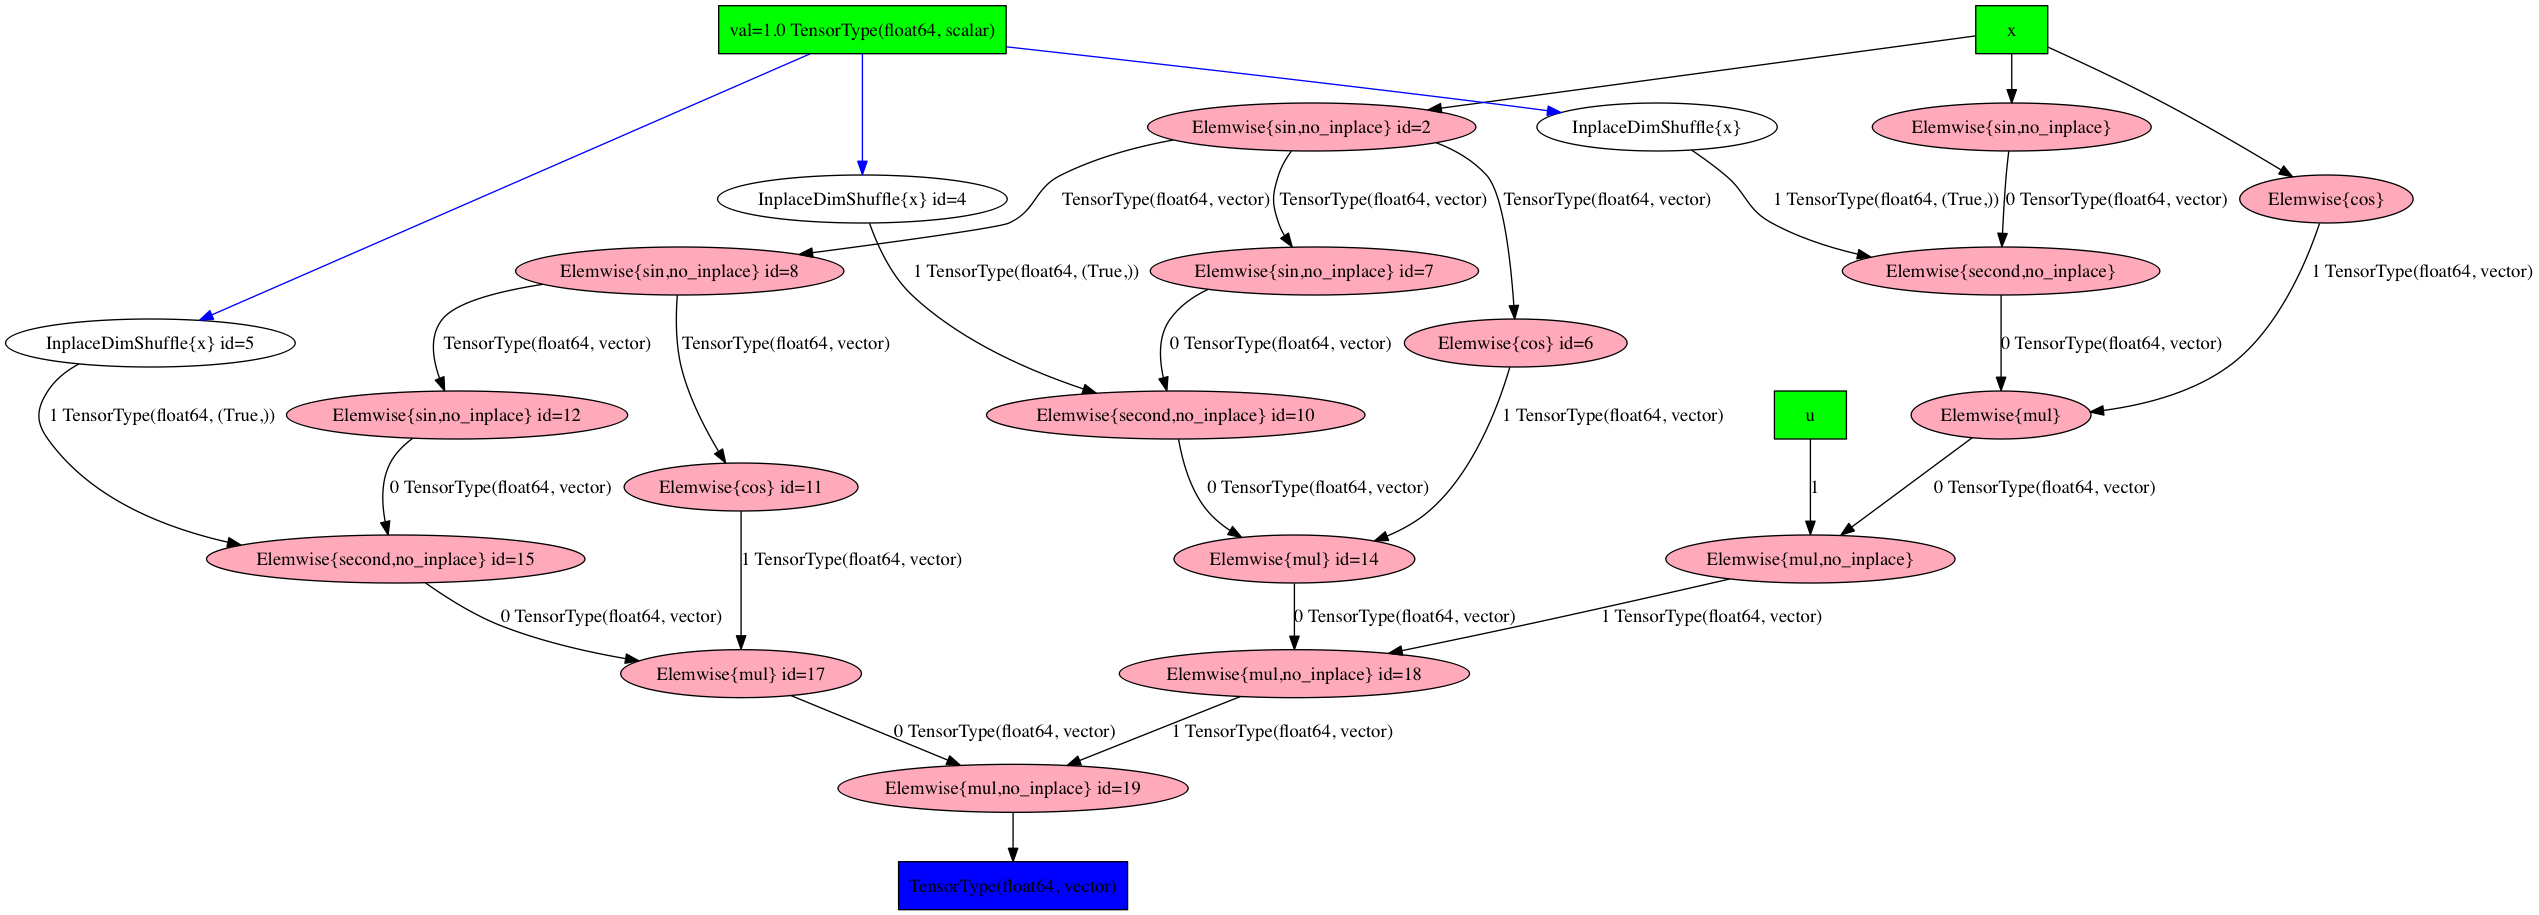

In [11]:
from IPython.display import Image
display(Image(theano.printing.pydotprint(jvp, return_image=True, var_with_name_simple=True)))

and the __alternative Rop__

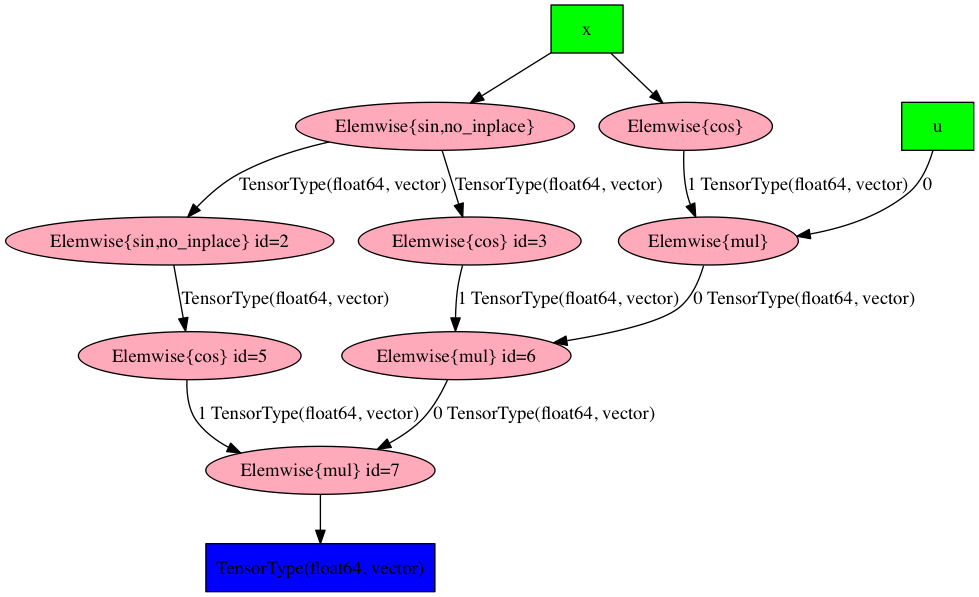

In [12]:
display(Image(theano.printing.pydotprint(alternative_jvp, return_image=True, var_with_name_simple=True)))

The pre-compilation graphs above appear to have the same chain-like structure, although the graph produced by the alternative Rop actually looks a lot simpler (whether this is something that would happen for general functions I do not know). Notice the variable `v` doesn't appear in the alternative Rop graph â€” Theano recognises that it's irrelevant to the final computation. After compilation the graphs appear to be exactly the same (albeit with the positions of the nodes swapped):

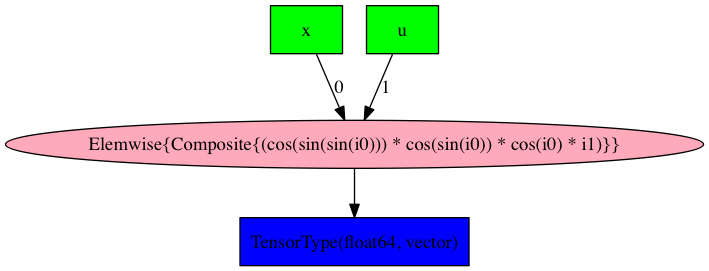

In [13]:
display(Image(theano.printing.pydotprint(jvp_compiled, return_image=True, var_with_name_simple=True)))

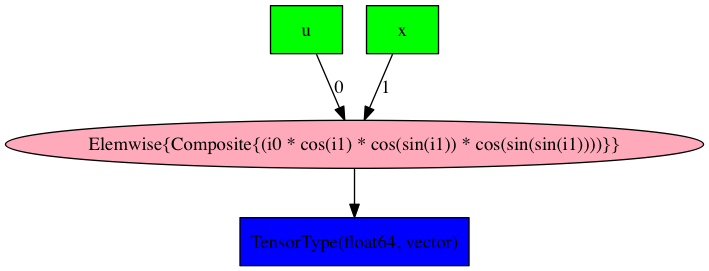

In [14]:
display(Image(theano.printing.pydotprint(alternative_jvp_compiled, return_image=True, var_with_name_simple=True)))